# CNN model

In [158]:
import torch
from torchtext import data
from torchtext import datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np

from pathlib import Path
import time

import csv

# Check if we are running on a CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [161]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [159]:
!pip install stanza 
import stanza
stanza.download(lang='et')
stanza_nlp = stanza.Pipeline(lang='et', processors='tokenize')

2021-05-08 09:40:05 INFO: Downloading default packages for language: et (Estonian)...
2021-05-08 09:40:06 INFO: File exists: /root/stanza_resources/et/default.zip.
2021-05-08 09:40:09 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-05-08 09:40:09 INFO: Loading these models for language: et (Estonian):
| Processor | Package |
-----------------------
| tokenize  | edt     |

2021-05-08 09:40:09 INFO: Use device: cpu
2021-05-08 09:40:09 INFO: Loading: tokenize
2021-05-08 09:40:09 INFO: Done loading processors!


In [162]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.et.300.vec.gz

--2021-05-08 09:41:25--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.et.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1209204423 (1.1G) [binary/octet-stream]
Saving to: ‘cc.et.300.vec.gz.1’

cc.et.300.vec.gz.1  100%[===================>]   1.13G  27.7MB/s    in 42s     

2021-05-08 09:42:08 (27.2 MB/s) - ‘cc.et.300.vec.gz.1’ saved [1209204423/1209204423]



In [163]:
!gunzip cc.et.300.vec.gz
!mkdir vector_cache/
!mv cc.et.300.vec vector_cache/

mkdir: cannot create directory ‘vector_cache/’: File exists


In [164]:
PAD = '<PAD>'
PAD_ID = 0
UNK = '<UNK>'
UNK_ID = 1

VOCAB_PREFIX = [PAD, UNK]

VEC_PATH = Path('vector_cache') / 'cc.et.300.vec'
DATA_PATH = Path('data')
MAX_VOCAB = 25000

batch_size = 64
test_split = .2
validation_split = .3
shuffle_dataset = True
random_seed = 42

In [165]:
class PretrainedWordVocab:
    def __init__(self, data, lower=False):
        self.data = data
        self.lower = lower
        self.build_vocab()
        
    def normalize_unit(self, unit):
        if self.lower:
            return unit.lower()
        else:
            return unit
        
    def unit2id(self, unit):
        unit = self.normalize_unit(unit)
        if unit in self._unit2id:
            return self._unit2id[unit]
        else:
            return self._unit2id[UNK]
    
    def id2unit(self, id):
        return self._id2unit[id]
    
    def map(self, units):
        return [self.unit2id(unit) for unit in units]
        
    def build_vocab(self):
        # self._id2unit - id to unit (add PAD and UNK)
        # self._unit2id - unit to id 
        self._id2unit =  VOCAB_PREFIX + self.data
        self._unit2id = {w:i for i,w in enumerate(self._id2unit)}
        
    def __len__(self):
        return len(self._unit2id)

In [166]:
class Pretrain:
    def __init__(self, vec_filename, max_vocab=-1):
        self._vec_filename = vec_filename
        self._max_vocab = max_vocab
        
    @property
    def vocab(self):
        if not hasattr(self, '_vocab'):
            self._vocab, self._emb = self.read()
        return self._vocab
    
    @property
    def emb(self):
        if not hasattr(self, '_emb'):
            self._vocab, self._emb = self.read()
        return self._emb
        
    def read(self):
        if self._vec_filename is None:
            raise Exception("Vector file is not provided.")
        print(f"Reading pretrained vectors from {self._vec_filename}...")
        
        words, emb, failed = self.read_from_file(self._vec_filename, open_func=open)
        
        if failed > 0: # recover failure
            emb = emb[:-failed]
        if len(emb) - len(VOCAB_PREFIX) != len(words):
            raise Exception("Loaded number of vectors does not match number of words.")
            
        # Use a fixed vocab size
        if self._max_vocab > len(VOCAB_PREFIX) and self._max_vocab < len(words):
            words = words[:self._max_vocab - len(VOCAB_PREFIX)]
            emb = emb[:self._max_vocab]
                
        vocab = PretrainedWordVocab(words, lower=True)
        
        return vocab, emb
        
    def read_from_file(self, filename, open_func=open):
        """
        Open a vector file using the provided function and read from it.
        """
        first = True
        words = []
        failed = 0
        with open_func(filename, 'rb') as f:
            for i, line in enumerate(f):
                try:
                    line = line.decode()
                except UnicodeDecodeError:
                    failed += 1
                    continue
                if first:
                    # the first line contains the number of word vectors and the dimensionality
                    first = False
                    line = line.strip().split(' ')
                    rows, cols = [int(x) for x in line]
                    emb = np.zeros((rows + len(VOCAB_PREFIX), cols), dtype=np.float32)
                    continue

                line = line.rstrip().split(' ')
                emb[i+len(VOCAB_PREFIX)-1-failed, :] = [float(x) for x in line[-cols:]]
                words.append(' '.join(line[:-cols]))
        return words, emb, failed

In [167]:
class NewsDataSet(Dataset):
    def __init__(self, pretrain, data_folder='.data', test=False):
        self.pretrain_vocab = pretrain.vocab
        self.label_vocab = {'elu24': 0, 'err': 1, 'paevaleht': 2, 'postimees': 3, 'telegram': 4, 'uued_uudised': 5}
        self.delimiters =  {'elu24': ';', 'err': ',', 'paevaleht': ',', 'postimees': ';', 'telegram': ',', 'uued_uudised': ','}
        self.contents_idx = {'elu24': 7, 'err': 5, 'paevaleht': 3, 'postimees': 6, 'telegram': 3, 'uued_uudised': 3}
        self.data_folder = data_folder    
        self.data = []
        
        if self.data_folder.exists():
            self.load()
        else:
            raise ValueError("Data path doesn't exist!")
        
    def load(self):
        for label in ['err', 'paevaleht', 'telegram', 'uued_uudised', 'elu24', 'postimees']:
            print(f'Reading {label} articles...')
            filename = label + '.csv'
            p = self.data_folder / filename
            with open(p, 'r', encoding='utf-8') as f:
                csv_reader = csv.reader(f, delimiter=self.delimiters[label])
                next(csv_reader) # header
                for row in csv_reader:
                    try:
                        row = next(csv_reader)
                        contents = row[self.contents_idx[label]]
                        if label in ['elu24', 'postimees']:
                            contents = contents.replace('|', '\n')
                        stanza_doc = stanza_nlp(contents)
                        tokenized = [[token.text for token in stanza_doc.sentences[i].tokens] for i in range(len(stanza_doc.sentences))]
                        flat_tokenized = flat_list = [item for sublist in tokenized for item in sublist]
                        self.data.append((self.pretrain_vocab.map(flat_tokenized), self.label_vocab[label]))
                    except:
                        continue

                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
p = DATA_PATH / 'postimees.csv'
with open(p, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=';')
    for row in reader:
        print(row[6].replace('|', '\n'))

In [169]:
pretrain = Pretrain(VEC_PATH, MAX_VOCAB)

In [170]:
def pad_sequences(batch):
  max_len = max([len(b[0]) for b in batch])

  padded_sequences = torch.zeros((len(batch), max_len), dtype=torch.long)
  labels = torch.zeros(len(batch), dtype=torch.float)

  for i, b in enumerate(batch):
    padded_sequences[i, :len(b[0])] = torch.LongTensor(b[0]) 
    labels[i] = b[1] 
  
  padded_sequences = padded_sequences.to(device)
  labels = labels.to(device)

  return padded_sequences, labels


In [171]:
data = NewsDataSet(pretrain, DATA_PATH)

Reading pretrained vectors from vector_cache/cc.et.300.vec...
Reading err articles...
Reading paevaleht articles...
Reading telegram articles...
Reading uued_uudised articles...
Reading elu24 articles...
Reading postimees articles...


In [172]:
# Creating data indices for training and validation splits:
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
val_split = int(np.floor(validation_split * len(train_indices)))
train_indices, val_indices = train_indices[val_split:], train_indices[:val_split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [173]:
train_loader = DataLoader(data, batch_size=batch_size, sampler=train_sampler, collate_fn=pad_sequences) 
validation_loader = DataLoader(data, batch_size=batch_size, sampler=valid_sampler, collate_fn=pad_sequences)
test_loader = DataLoader(data, batch_size=batch_size, sampler=test_sampler, collate_fn=pad_sequences)

In [174]:
class CNN(nn.Module):
    def __init__(self, pretrain, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding.from_pretrained(
            torch.from_numpy(pretrain.emb), 
            padding_idx=pad_idx, 
            freeze=True
        )
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):           
        #text = [batch size, sent len]

        embedded = self.embedding(text)     
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)  
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]    
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]     
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        #return F.log_softmax(self.fc(cat), dim=1)
        return F.log_softmax(self.fc(cat), dim=1)

In [175]:
INPUT_DIM = len(pretrain.vocab)
EMBEDDING_DIM = pretrain.emb.shape[1]
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 6
DROPOUT = 0.5

model = CNN(pretrain, INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_ID)

In [176]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [177]:
def accuracy(preds, y): 
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(1).long()
    correct = (max_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [178]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
      optimizer.zero_grad()
      predictions = model(batch[0]).squeeze(1) 
      loss = criterion(predictions, batch[1].long())
      acc = accuracy(predictions, batch[1].long())
      loss.backward()
      optimizer.step()

      epoch_loss += loss 
      epoch_acc += acc 
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [179]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    preds = []
    golds = []

    with torch.no_grad():
      for batch in iterator: 
        predictions = model(batch[0]).squeeze(1)
        loss = criterion(predictions, batch[1].long())
        acc = accuracy(predictions, batch[1].long())
        epoch_loss += loss 
        epoch_acc += acc
        preds.extend(predictions.argmax(1).long())
        golds.extend(batch[1].long())
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), preds, golds

In [180]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [181]:
N_EPOCHS = 5

best_valid_loss = float('inf')
final_preds = []
final_golds = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, preds, golds = evaluate(model, validation_loader, criterion)
    final_preds.extend(preds)
    final_golds.extend(golds)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'news_cnn_classifier.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 5m 26s
	Train Loss: 1.576 | Train Acc: 34.43%
	 Val. Loss: 1.337 |  Val. Acc: 53.35%
Epoch: 02 | Epoch Time: 5m 29s
	Train Loss: 1.124 | Train Acc: 62.62%
	 Val. Loss: 0.950 |  Val. Acc: 66.57%
Epoch: 03 | Epoch Time: 5m 15s
	Train Loss: 0.845 | Train Acc: 67.95%
	 Val. Loss: 0.789 |  Val. Acc: 65.18%
Epoch: 04 | Epoch Time: 5m 21s
	Train Loss: 0.725 | Train Acc: 72.53%
	 Val. Loss: 0.696 |  Val. Acc: 69.05%
Epoch: 05 | Epoch Time: 5m 29s
	Train Loss: 0.625 | Train Acc: 76.12%
	 Val. Loss: 0.662 |  Val. Acc: 67.91%


In [182]:
final_preds = []
final_golds = []

start_time = time.time()
test_loss, test_acc, preds, golds = evaluate(model, test_loader, criterion)
final_preds.extend(preds)
final_golds.extend(golds)
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)

print(f'Epoch: test | Epoch Time: {epoch_mins}m {epoch_secs}s')
print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch: test | Epoch Time: 0m 26s
	Test Loss: 0.685 | Test Acc: 68.55%


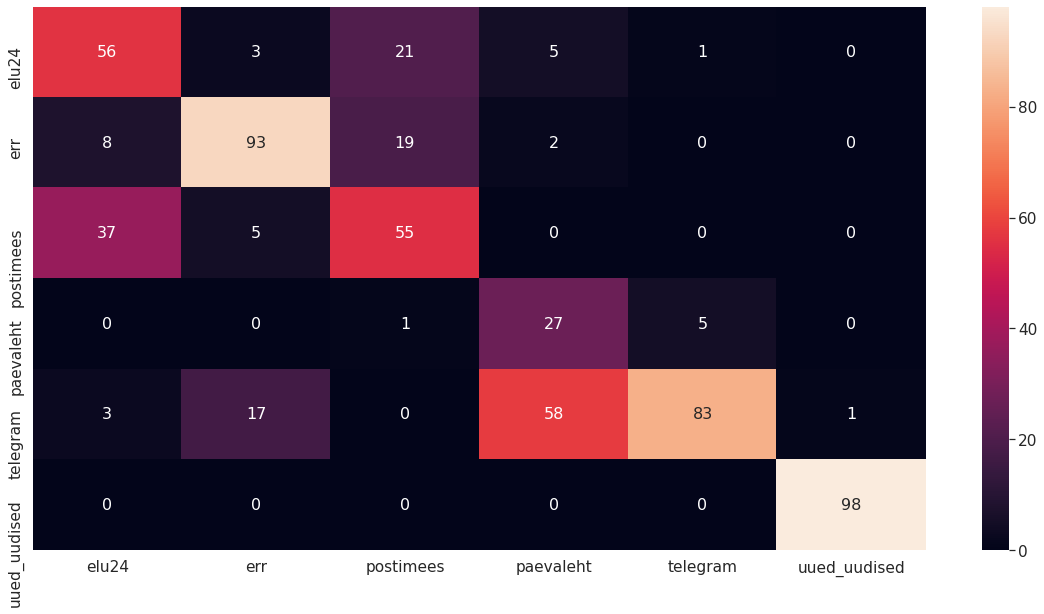

In [183]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

vocab = {0: 'elu24', 1 : 'err', 2 : 'paevaleht', 3 : 'postimees', 4 : 'telegram', 5: 'uued_uudised'}

preds = [vocab[i.item()] for i in final_preds]
golds = [vocab[i.item()] for i in final_golds]

labels = list(set(preds).union(set(golds)))

cm = confusion_matrix(preds, golds, labels=labels)

df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize=(20, 10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

plt.show()